In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys
sys.path.append('../')
import adaprobe

In [3]:
import jax
import jax.numpy as jnp

In [4]:
fontsize=14

In [5]:
print(os.listdir('data'))
fname = '201119_cell7_A'

['SST_210608_cell1_map_A.npz', '.ipynb_checkpoints', 'SST_210609_cell3_map_A.npz', 'PV_210626_cell7_map_A.npz', 'PV_210601_cell8_map_A.npz', 'SST_210609_cell5_map_A.npz', 'one_cell_per_plane_plus_10_random_201119_cell2_A.npz', 'one_cell_per_plane_plus_10_random_201119_cell7_A.npz', 'one_cell_per_plane_sample_data.npz', 'PV_210601_cell6_map_A.npz', 'one_cell_per_plane_plus_10_random_201118_cell1_A.npz', 'SST_210609_cell1_map_A.npz', 'SST_210607_cell2_map_A.npz', 'PV_210623_cell4_map_A.npz', 'SST_210609_cell2_map_A.npz', 'one_cell_per_plane_plus_10_random_201121_cell1_A.npz', 'PV_210623_cell5_map_A.npz']


In [6]:
data = np.load('data/one_cell_per_plane_plus_10_random_%s.npz'%fname)

In [7]:
y = data['y']
stimulus_matrix = data['stimulus_matrix']
y_psc = data['y_psc']
N, K = stimulus_matrix.shape
trial_length = y_psc.shape[1]
n_repeats = K//N

In [8]:
ispectra = np.array([np.max(scipy.signal.correlate(y_psc[i], y_psc[i])) for i in range(K)])

In [9]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior,
    'shape': 1,
    'rate': 1e-1
}

fit_options = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'penalty': 5,
    'max_penalty_iters': 15,
    'lam_masking': True,
    'scale_factor': 0.65,
    'warm_start_lasso': False,
    'constrain_weights': True,
    'verbose': False,
    'y_xcorr_thresh': 0.02
}

model = adaprobe.Model(N, model_type='mbcs', priors=priors)

In [10]:
model.reset()
%time model.fit((y, y_psc), stimulus_matrix, fit_options=fit_options, method='mbcs')

CPU times: user 11.4 s, sys: 1.28 s, total: 12.6 s
Wall time: 9.26 s


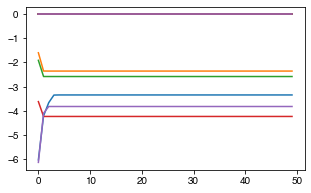

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(model.history['mu'])
# plt.legend(range(N))
plt.show()

In [13]:
lam = np.array(model.state['lam']).T
alpha = np.array(model.state['mu'] != 0).astype(float)

phi = model.state['phi']
phi_cov = model.state['phi_cov']
phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
plow = phi - phi_sdevs
phigh = phi + phi_sdevs

Irng = np.arange(0, 91)

xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

post = [gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
postmax = np.max(post)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

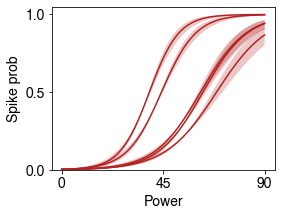

In [14]:
plt.figure(figsize=(4, 3))
for n in range(5):
    if alpha[n] < 0.5:
        sigcol = 'gray'
    else:
        sigcol = 'firebrick'
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color=sigcol)
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor=sigcol, edgecolor='None', alpha=0.25)
plt.xlabel('Power', fontsize=fontsize)
plt.ylabel('Spike prob', fontsize=fontsize)
plt.ylim([0, 1.05])
plt.yticks([0, 0.5, 1], fontsize=fontsize)
plt.xticks([0, 45, 90], fontsize=fontsize)
# plt.savefig('receptive_field_posteriors_%s.png'%fname, format='png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

<ipython-input-214-c2190d5a7a68>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


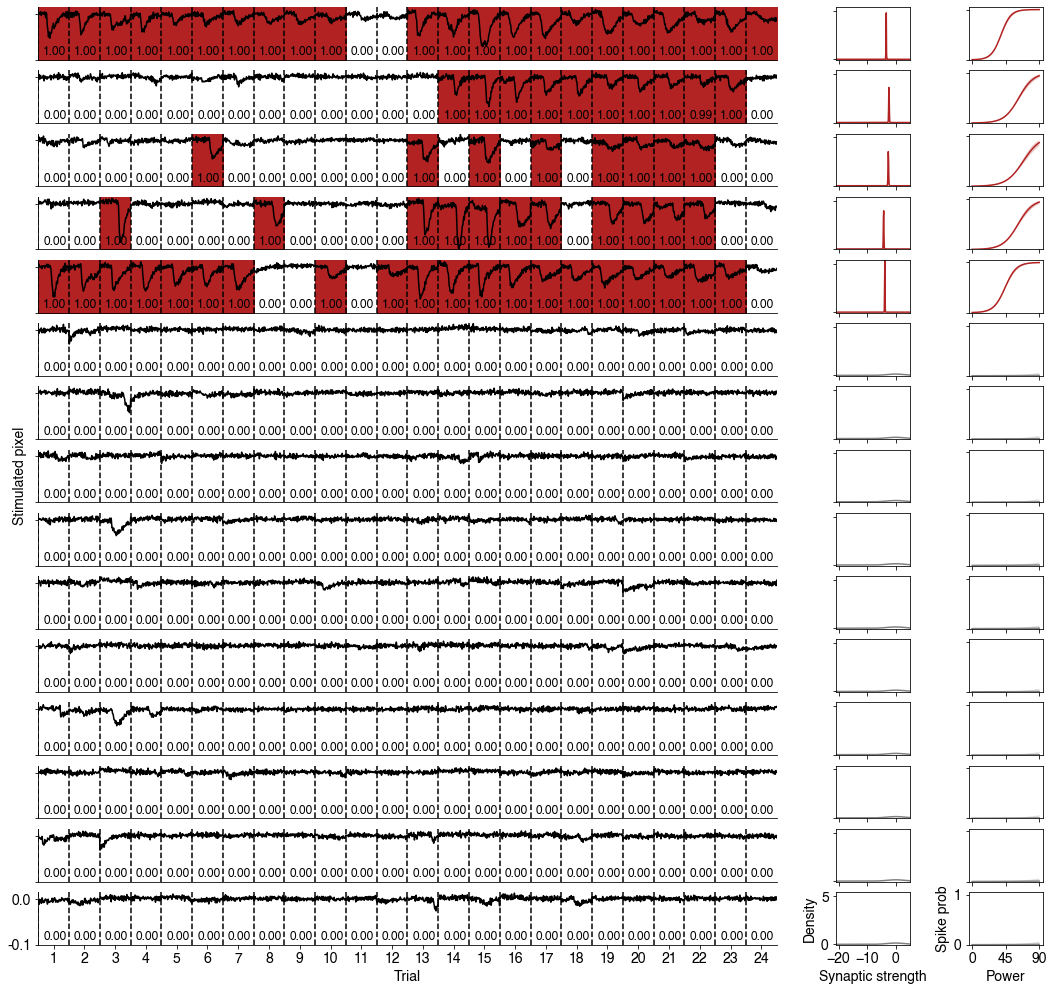

In [214]:
trial_breaks = np.arange(0, trial_length * n_repeats + 1, trial_length)

plt.figure(figsize=(18, 1.15 * N))
gs = gridspec.GridSpec(N, 3, width_ratios=[15, 1.5, 1.5])
    
for n in range(N):
    # Spike predictions
    plt.subplot(gs[n, 0])
    stim_locs = np.where(stimulus_matrix[n] > 0)[0]
    this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
    fill_lower = -1
    fill_upper = 0.15
    plt.xlim([0, trial_length*n_repeats])
    plt.ylim([-1, 0.15])
    for tb in range(len(trial_breaks) - 1):
        plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
        plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb] * alpha[n])
        plt.text(trial_breaks[tb] + trial_length/2 - 100, -0.9, '%.2f'%lam[n, stim_locs][tb], fontsize=fontsize-2)
    plt.plot(this_y_psc, color='k')
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    
    if n == N-1:
        plt.xticks(trial_breaks[:-1] + trial_length/2, fontsize=fontsize)
        plt.gca().set_xticklabels(np.arange(1, n_repeats+1))
        plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
        plt.xlabel('Trial', fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    elif n == N//2:
        plt.ylabel('Stimulated pixel', fontsize=fontsize)
        plt.xticks([])
        plt.gca().set_yticklabels([])
    else:
        plt.xticks([])
        plt.gca().set_yticklabels([])
        
    # Synapses
    plt.subplot(gs[n, 1])
    syn_col = 'gray' if alpha[n] == 0 else 'firebrick'
    plt.plot(xrange, post[n], color=syn_col)
    plt.xlim(np.min(xrange), np.max(xrange))
    plt.ylim([-0.05, postmax])
    if n < N-1:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    else:
        plt.xlabel('Synaptic strength', fontsize=fontsize)
        plt.ylabel('Density', fontsize=fontsize)
    plt.xticks(np.arange(-20, 1, 10), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    # Spike-power relationship
    plt.subplot(gs[n, 2])
    if alpha[n] < 0.5:
        sigcol = 'gray'
    else:
        sigcol = 'firebrick'
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), color=sigcol)
    plt.fill_between(Irng, sigmoid(plow[n, 0] * Irng - plow[n, 1]), sigmoid(phigh[n, 0] * Irng - phigh[n, 1]), facecolor=sigcol, edgecolor='None', alpha=0.25)
    if n == N-1:
        plt.xlabel('Power', fontsize=fontsize)
        plt.ylabel('Spike prob', fontsize=fontsize)
    else:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    plt.ylim([0, 1.05])
    plt.yticks([0, 1], fontsize=fontsize)
    plt.xticks([0, 45, 90], fontsize=fontsize)
    
# plt.savefig('figs/model_based_cs/one_cell_per_plane_plus_10_random_%s.pdf'%fname, format='pdf', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

In [215]:
tar_matrix = (stimulus_matrix > 0).astype(float)
lam = model.state['lam'].T
psc_shapes = (lam @ y_psc)/np.sum(tar_matrix, 1)[:, None]
lam_avg = np.nan_to_num(lam/np.sum(lam, 1)[:, None])
c = (lam_avg @ y_psc)

<ipython-input-215-e72367daa311>:4: RuntimeWarning: invalid value encountered in true_divide
  lam_avg = np.nan_to_num(lam/np.sum(lam, 1)[:, None])


PSC shape estimated by $\begin{align}\tilde\lambda_{n}^\top y_\text{psc} \end{align}$, where $\tilde\lambda_n = \lambda_n/||\lambda_n||_1$ defines a probability mass.

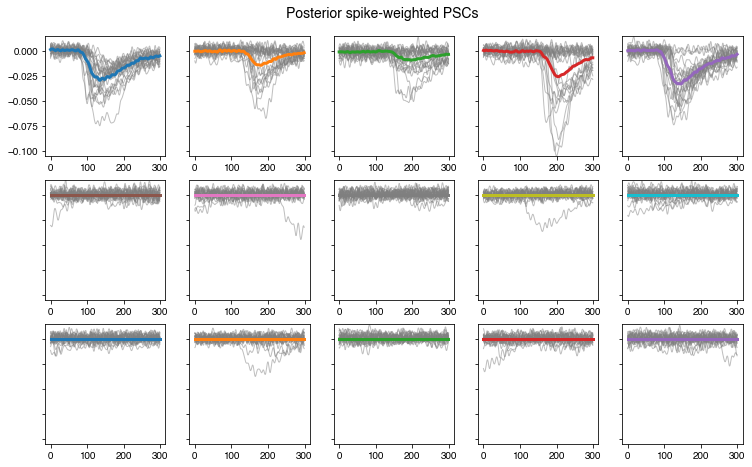

In [216]:
panel_size = 2.5
nrows = 3
ncols = 5
plt.figure(figsize=(panel_size * ncols, panel_size * nrows))
ylower = np.min(y_psc)
yupper = np.max(y_psc)
for n in range(N):
    tar_trials = np.where(tar_matrix[n])[0]
    plt.subplot(nrows, ncols, n+1)
    plt.plot(y_psc[tar_trials].T, color='gray', alpha=0.5, linewidth=1)
    plt.plot(psc_shapes[n], linewidth=3, color='C%i'%n)
    plt.ylim([ylower, yupper])
    if n > 0:
        plt.gca().set_yticklabels([])
plt.suptitle('Posterior spike-weighted PSCs', fontsize=fontsize, y=0.935)
# plt.savefig('figs/model_based_cs/psc_inference/nonparametric_pscs_cell_%s.pdf'%fname, format='pdf', bbox_inches='tight', facecolor='white')
plt.show()

# Integrating against PSC kernel

In [217]:
def get_kernel(tau_r, tau_d, d):
    def func(t):
        return (np.exp(-(t - d)/tau_d) - np.exp(-(t - d)/tau_r)) * (t > d)
    return func

In [218]:
tau_r = 70
tau_d = 100
d = 80
kern = get_kernel(tau_r, tau_d, d)
krange = np.linspace(0, 300, 300)
kernel = kern(krange)
kernel /= np.max(kernel)

In [219]:
filt_y_psc = y_psc * kernel

In [220]:
tar_matrix = (stimulus_matrix > 0).astype(float)

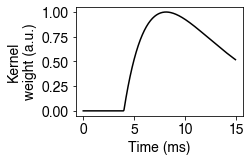

In [221]:
plt.figure(figsize=(3, 2))
plt.plot(kernel, color='k')
plt.ylabel('Kernel\nweight (a.u.)', fontsize=fontsize)
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.xticks(np.arange(0, 301, 100), fontsize=fontsize)
plt.gca().set_xticklabels(np.arange(0, 16, 5))
plt.yticks(fontsize=fontsize)
# plt.savefig('figs/model_based_cs/model_fit_psc_integrated_against_kernel_sample_kernel.pdf', 
#             format='pdf', bbox_inches='tight')
plt.show()

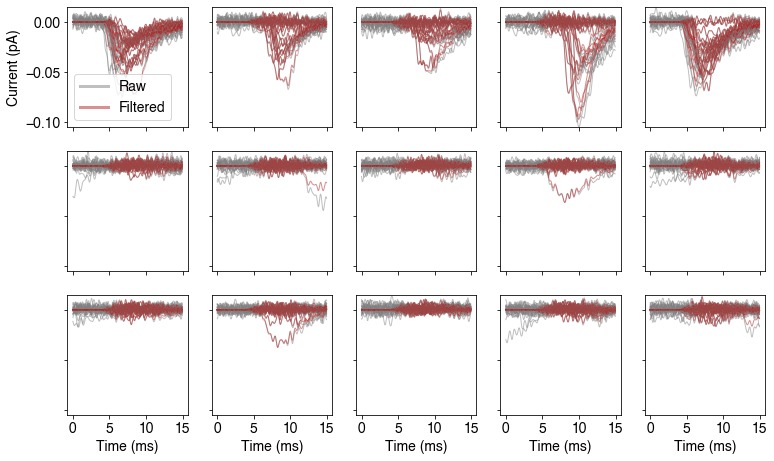

In [222]:
panel_size = 2.5
nrows = 3
ncols = 5
plt.figure(figsize=(panel_size * ncols, panel_size * nrows))
ylower = np.min(y_psc)
yupper = np.max(y_psc)
for n in range(N):
    tar_trials = np.where(tar_matrix[n])[0]
    plt.subplot(nrows, ncols, n+1)
    for indx, tr in enumerate(tar_trials):
        if indx == 0:
            label_raw = 'Raw'
            label_filt = 'Filtered'
        else:
            label_raw = ''
            label_filt = ''
        plt.plot(y_psc[tr], color='gray', alpha=0.5, linewidth=1, label=label_raw)
        plt.plot(filt_y_psc[tr], color='firebrick', alpha=0.5, linewidth=1, label=label_filt)
    plt.ylim([ylower, yupper])
    plt.yticks([-0.1, -0.05, 0], fontsize=fontsize)
    
    if n > 0:
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Current (pA)', fontsize=fontsize)
        leg = plt.legend(fontsize=fontsize)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3)
            
    plt.xticks(np.arange(0, 301, 100), fontsize=fontsize)
    if n > 9:
        plt.gca().set_xticklabels(np.arange(0, 16, 5))
        plt.xlabel('Time (ms)', fontsize=fontsize)
    else:
        plt.gca().set_xticklabels([])
# plt.savefig('figs/model_based_cs/psc_integrated_against_kernel_cell_%s.pdf'%fname, format='pdf', bbox_inches='tight', facecolor='white')
plt.show()

In [223]:
filt_y = np.trapz(filt_y_psc, axis=1)

In [224]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior,
    'shape': 1,
    'rate': 1e-1
}

fit_options = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'penalty': 5,
    'max_penalty_iters': 15,
    'lam_masking': True,
    'scale_factor': 0.65,
    'warm_start_lasso': False,
    'constrain_weights': True,
    'verbose': False,
    'y_xcorr_thresh': 0.02
}

model_filt = adaprobe.Model(N, model_type='mbcs', priors=priors)

In [225]:
model_filt.reset()
%time model_filt.fit((filt_y, filt_y_psc), stimulus_matrix, fit_options=fit_options, method='mbcs')

CPU times: user 3.28 s, sys: 386 ms, total: 3.66 s
Wall time: 2.88 s


In [226]:
lam = np.array(model_filt.state['lam']).T
alpha = np.array(model_filt.state['mu'] != 0).astype(float)

alpha_raw = np.array(model.state['mu'] != 0).astype(float)

phi_filt = model_filt.state['phi']
phi_cov_filt = model_filt.state['phi_cov']
phi_sdevs_filt = np.sqrt(np.array([np.diag(phi_cov_filt[n]) for n in range(N)]))
plow_filt = phi_filt - phi_sdevs_filt
phigh_filt = phi_filt + phi_sdevs_filt

Irng = np.arange(0, 91)

xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

post_filt = [gaussf(model_filt.state['mu'][n], model_filt.state['beta'][n]) for n in range(N)]
postmax_filt = np.max(post_filt)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

<ipython-input-229-9ee7b7e78a65>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])


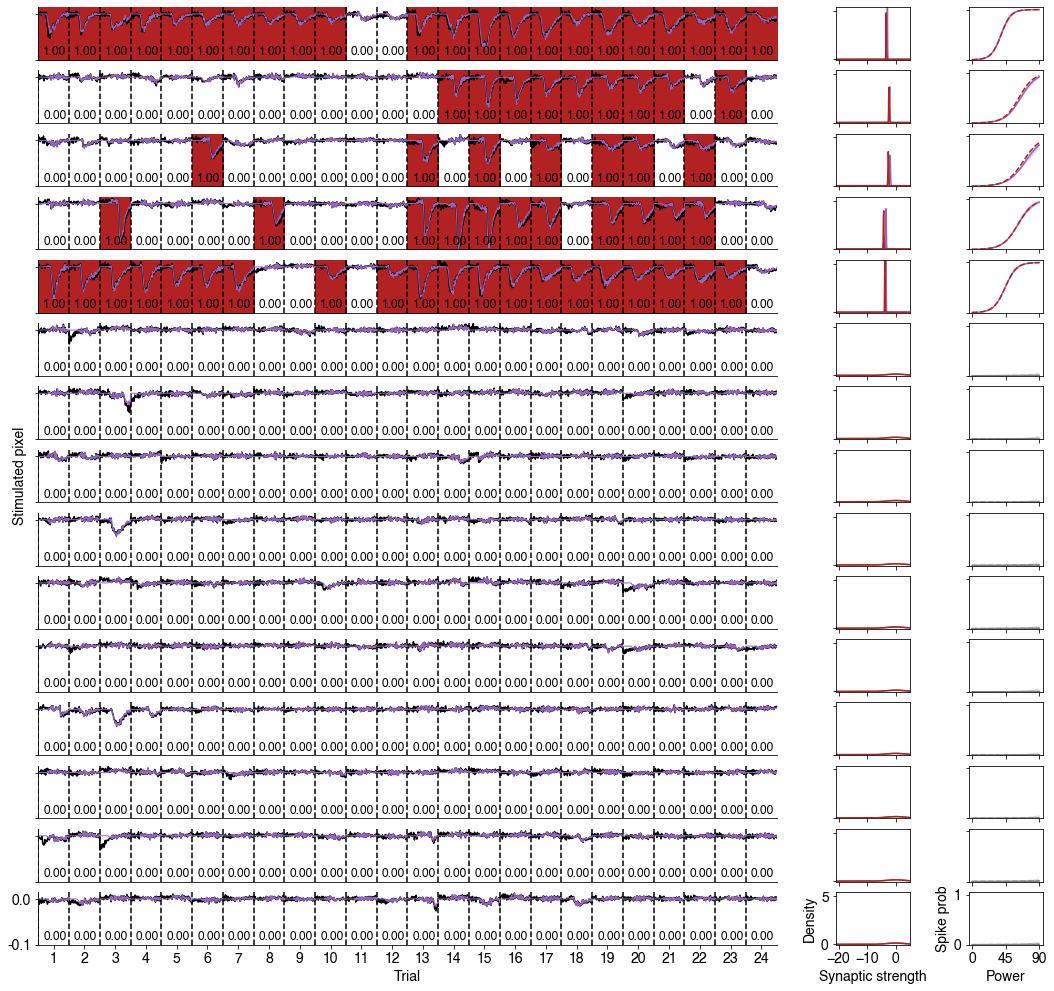

In [229]:
trial_breaks = np.arange(0, trial_length * n_repeats + 1, trial_length)

plt.figure(figsize=(18, 1.15 * N))
gs = gridspec.GridSpec(N, 3, width_ratios=[15, 1.5, 1.5])
    
for n in range(N):
    # Spike predictions
    plt.subplot(gs[n, 0])
    stim_locs = np.where(stimulus_matrix[n] > 0)[0]
    this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
    this_filt_y_psc = filt_y_psc[stim_locs].flatten()/np.max(np.abs(filt_y_psc))
    fill_lower = -1
    fill_upper = 0.15
    plt.xlim([0, trial_length*n_repeats])
    plt.ylim([-1, 0.15])
    for tb in range(len(trial_breaks) - 1):
        plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
        plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb] * alpha[n])
        plt.text(trial_breaks[tb] + trial_length/2 - 100, -0.9, '%.2f'%lam[n, stim_locs][tb], fontsize=fontsize-2)
    plt.plot(this_y_psc, color='k', linewidth=1.5)
    plt.plot(this_filt_y_psc, '-', color='C4', linewidth=1)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    
    if n == N-1:
        plt.xticks(trial_breaks[:-1] + trial_length/2, fontsize=fontsize)
        plt.gca().set_xticklabels(np.arange(1, n_repeats+1))
        plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
        plt.xlabel('Trial', fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    elif n == N//2:
        plt.ylabel('Stimulated pixel', fontsize=fontsize)
        plt.xticks([])
        plt.gca().set_yticklabels([])
    else:
        plt.xticks([])
        plt.gca().set_yticklabels([])
        
    # Synapses
    plt.subplot(gs[n, 1])
    syn_col = 'gray' if alpha[n] == 0 else 'C4'
    plt.plot(xrange, post_filt[n], color=syn_col)
    plt.plot(xrange, post[n], color='firebrick')
    plt.xlim(np.min(xrange), np.max(xrange))
    plt.ylim([-0.05, postmax])
    if n < N-1:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    else:
        plt.xlabel('Synaptic strength', fontsize=fontsize)
        plt.ylabel('Density', fontsize=fontsize)
    plt.xticks(np.arange(-20, 1, 10), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    # Spike-power relationship
    plt.subplot(gs[n, 2])
    if alpha[n] < 0.5:
        sigcol = 'gray'
    else:
        sigcol = 'C4'
    # filtered psc
    plt.plot(sigmoid(phi_filt[n, 0] * Irng - phi_filt[n, 1]), color=sigcol)
    plt.fill_between(Irng, sigmoid(plow_filt[n, 0] * Irng - plow_filt[n, 1]), sigmoid(phigh_filt[n, 0] * Irng - phigh_filt[n, 1]), facecolor=sigcol, edgecolor='None', alpha=0.25)
    
    # raw psc
    sigcol_raw = 'gray' if alpha_raw[n] < 0.5 else 'firebrick'
    plt.plot(sigmoid(phi[n, 0] * Irng - phi[n, 1]), '--', color=sigcol_raw)
    
    if n == N-1:
        plt.xlabel('Power', fontsize=fontsize)
        plt.ylabel('Spike prob', fontsize=fontsize)
    else:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    plt.ylim([0, 1.05])
    plt.yticks([0, 1], fontsize=fontsize)
    plt.xticks([0, 45, 90], fontsize=fontsize)
    
# plt.savefig('figs/model_based_cs/model_fit_psc_integrated_against_kernel_%s.pdf'%fname, format='pdf', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()

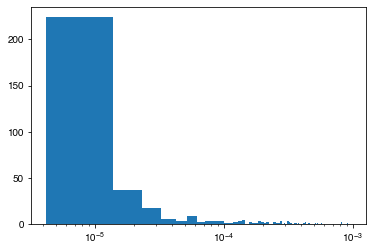

In [228]:
plt.figure()
plt.hist(np.var(y_psc, 1), 100)
plt.xscale('log')
plt.show()

In [ ]:
plt.figure()
plt.hist(np.var(y_psc, 1), 100)
plt.show()

In [ ]:
plt.figure()
plt.hist(np.array([np.correlate(y_psc[i], y_psc[i]) for i in range(y_psc.shape[0])]).squeeze(), 100)
plt.show()

In [ ]:
for i in range(5):
    plt.figure()
    plt.plot(y_psc[i])
    plt.show()
    print(np.var(y_psc[i]))

# Simulating multi-spot stimulation

In [ ]:
powers = np.unique(stimulus_matrix[stimulus_matrix > 0])
R = 12
# Kmulti = int(np.ceil(K/R))
Kmulti = K
trial_len = y_psc.shape[1]

In [ ]:
y_psc_multi = np.zeros((Kmulti, trial_len))
stimulus_matrix_multi = np.zeros((N, Kmulti))

for k in range(Kmulti):
    tars = np.random.choice(N, R, replace=False)
    power = np.random.choice(powers)
    sampled_trials = [np.random.choice(np.where(stimulus_matrix[tar] == power)[0]) for tar in tars]
    y_psc_multi[k] = np.sum(y_psc[sampled_trials], 0)
    stimulus_matrix_multi[tars, k] = power

y_multi = np.trapz(y_psc_multi, axis=1)

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(stimulus_matrix_multi, aspect='auto', interpolation='nearest')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 1))
plt.plot(np.trapz(y_psc_multi, axis=1))
plt.xlim([0, Kmulti])
plt.axis('off')
plt.show()

In [ ]:
# configure priors
phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
beta_prior = 3e0 * np.ones(N)
mu_prior = np.zeros(N)

priors = {
    'alpha': np.ones(N),
    'beta': beta_prior,
    'mu': mu_prior,
    'phi': phi_prior,
    'phi_cov': phi_cov_prior
}

fit_options = { 
    'iters': 50,
    'num_mc_samples': 500,
    'seed': 0,
    'penalty': 5,
    'max_penalty_iters': 15,
    'lam_masking': True,
    'scale_factor': 0.65,
    'warm_start_lasso': False,
    'constrain_weights': True,
    'verbose': False,
}

model = adaprobe.Model(N, model_type='mbcs', priors=priors)


In [ ]:
model.reset()
%time model.fit((y_multi, y_psc_multi), stimulus_matrix_multi, fit_options=fit_options, method='mbcs')

In [ ]:
Irng = np.arange(0, 91)
xrange = np.arange(-16, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [ ]:
def plot_inferred_spikes_multi(y_psc, stimulus_matrix, model, save=None):
    lam = np.array(model.state['lam']).T
#     alpha = np.array(model.state['alpha'])
    alpha = np.array((model.state['mu'] != 0).astype(float))
    
    phi = model.state['phi']
    phi_cov = model.state['phi_cov']
    phi_sdevs = np.sqrt(np.array([np.diag(phi_cov[n]) for n in range(N)]))
    plow = phi - phi_sdevs
    phigh = phi + phi_sdevs

    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)

    max_trial_breaks = 30
    trial_breaks = np.arange(0, trial_length * max_trial_breaks + 1, trial_length)

    plt.figure(figsize=(25, 1.15 * N))
    gs = gridspec.GridSpec(N, 2, width_ratios=[15, 1.5])

    for n in range(N):
        # Spike predictions
        plt.subplot(gs[n, 0])
        stim_locs = np.where(stimulus_matrix[n] > 0)[0]
        this_y_psc = y_psc[stim_locs].flatten()/np.max(np.abs(y_psc))
        fill_lower = -1
        fill_upper = 0.15
        plt.ylim([-1, 0.15])
        tbmax = np.min([len(trial_breaks) - 1, len(stim_locs)])
        plt.xlim([0, trial_length*tbmax])
        for tb in range(tbmax):
            plt.plot([trial_breaks[tb], trial_breaks[tb]], [-1, 0.15], '--', color='k')
            plt.fill_between(np.arange(trial_length * tb, trial_length * (tb + 1)), fill_lower * np.ones(trial_length), fill_upper * np.ones(trial_length), color='firebrick', alpha=lam[n, stim_locs][tb] * alpha[n])
            plt.text(trial_breaks[tb] + trial_length/2 - 70, -0.9, '%.2f'%(lam[n, stim_locs][tb]))
        plt.plot(this_y_psc[:tbmax*trial_len], color='k')
        for loc in ['top', 'right']:
            plt.gca().spines[loc].set_visible(False)

        if n == N-1:
#             plt.xticks(trial_breaks[:-1] + trial_length/2)
#             plt.gca().set_xticklabels(np.arange(1, tbmax+1))
            plt.gca().set_yticklabels([np.round(np.min(y_psc), 2), 0.])
            plt.xlabel('Trial', fontsize=fontsize)
        elif n == N//2:
            plt.ylabel('PSC', fontsize=fontsize)
            plt.xticks([])
            plt.gca().set_yticklabels([])
        else:
            plt.xticks([])
            plt.gca().set_yticklabels([])

        # Synapses
        plt.subplot(gs[n, 1])
        plt.plot(xrange, post[n], color='firebrick')
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([-0.05, postmax])
        if n < N-1:
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
        else:
            plt.xlabel('Synaptic strength', fontsize=fontsize)
            plt.ylabel('Density', fontsize=fontsize)
#         plt.xticks(np.arange(-20, 1, 10))
#         plt.yticks([0, 0.4, 0.8])
    
    if save:
        plt.savefig('figs/model_based_cs/multi_spot_data_from_recombined_single_spot_R%i_K%i_%s.png'%(R, Kmulti, fname), format='png', bbox_inches='tight', dpi=200, facecolor='white')
        
    plt.show()


In [ ]:
plot_inferred_spikes_multi(y_psc_multi, stimulus_matrix_multi, model, save=False)

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot([-6, 1], [-6, 1], '--', color='gray')
plt.scatter(model.state['mu'], model_ms.state['mu'], edgecolor='C1', facecolor='None', linewidth=3)
plt.xlim([-6, 2])
plt.ylim([-6, 2])
plt.xticks(np.arange(-6, 2, 2))
plt.yticks(np.arange(-6, 2, 2))
plt.ylabel('Inferred multi-spot mapping', fontsize=fontsize)
plt.xlabel('Inferred single-spot mapping', fontsize=fontsize)
plt.grid(linestyle='dashed')
plt.show()

In [ ]:
np.corrcoef(model.state['mu'], model_ms.state['mu'])

# Simulate multiple multispot expts for comparison

In [ ]:
powers = np.unique(stimulus_matrix[stimulus_matrix > 0])
R = 2
Kmulti = [K//4, K//2, K]
nks = len(Kmulti)
trial_len = y_psc.shape[1]
y_psc_multi = [None for _ in range(nks)]
stimulus_matrix_multi = [None for _ in range(nks)]
y_multi = [None for _ in range(nks)]

In [ ]:
for kindx, this_K in enumerate(Kmulti):
    y_psc_multi[kindx] = np.zeros((this_K, trial_len))
    stimulus_matrix_multi[kindx] = np.zeros((N, this_K))

    for k in range(this_K):
        tars = np.random.choice(N, R, replace=False)
        power = np.random.choice(powers)
        sampled_trials = [np.random.choice(np.where(stimulus_matrix[tar] == power)[0]) for tar in tars]
        y_psc_multi[kindx][k] = np.sum(y_psc[sampled_trials], 0)
        stimulus_matrix_multi[kindx][tars, k] = power

    y_multi[kindx] = np.trapz(y_psc_multi[kindx], axis=1)

In [ ]:
# # configure priors
# phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
# phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
# beta_prior = 3e0 * np.ones(N)
# mu_prior = np.zeros(N)

# priors = {
#     'alpha': np.ones(N),
#     'beta': beta_prior,
#     'mu': mu_prior,
#     'phi': phi_prior,
#     'phi_cov': phi_cov_prior
# }

# fit_options = {
#     'penalty': 5e-2,
#     'iters': 100,
#     'num_mc_samples': 50,
#     'seed': 1,
#     'learn_alpha': False
# #     'lam_mask': 
# }

models = [adaprobe.Model(np.zeros(N), priors=priors) for _ in range(nks)]

In [ ]:
for kindx in range(nks):
    %time models[kindx].fit(y_multi[kindx], stimulus_matrix_multi[kindx], fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

In [ ]:
for kindx in range(nks):
    plot_inferred_spikes_multi(y_psc_multi[kindx], stimulus_matrix_multi[kindx], models[kindx])

In [ ]:
plt.plot(y_psc_multi[0][0])
plt.plot(y_psc_multi[0][1])

In [ ]:
jnp.correlate(y_psc_multi[0][0], y_psc_multi[0][0])

In [ ]:
jnp.correlate(y_psc_multi[0][1], y_psc_multi[0][1])

In [ ]:
corrs = np.array([jnp.correlate(y_psc_multi[0][i], y_psc_multi[0][i]) for i in range(Kmulti[0])]).squeeze()

In [ ]:
plt.plot(np.sort(corrs)[::-1])

In [ ]:
corrs

In [ ]:
plt.hist(corrs, 20, cumulative=True)

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot([-6, 2], [-6, 2], '--', color='gray')
for kindx in range(nks):
    plt.scatter(model.state['mu'], models[kindx].state['mu'], edgecolor='C%i'%kindx, facecolor='None', linewidth=3, \
                label='K=%i, %i%% single-spot trials, $r^2$=%.2f'%(Kmulti[kindx], 100*Kmulti[kindx]/K, \
                np.square(np.corrcoef(model.state['mu'], models[kindx].state['mu'])[0, 1])))
plt.xlim([-7, 3])
plt.ylim([-7, 3])
plt.xticks(np.arange(-6, 3, 2))
plt.yticks(np.arange(-6, 3, 2))
plt.ylabel('Inferred multi-spot mapping (R=%i)'%R, fontsize=fontsize)
plt.xlabel('Inferred single-spot mapping', fontsize=fontsize)
plt.grid(linestyle='dashed')
plt.legend(loc='upper left', frameon=True)
plt.show()

In [ ]:
for kindx in range(nks):
    print(np.corrcoef(model.state['mu'], models[kindx].state['mu'])[0, 1])